# Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from joblib import dump

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, log_loss, classification_report, roc_auc_score, roc_curve, confusion_matrix

# Configuration parameters

In [3]:
current_dir = os.getcwd()

X_train_path = os.path.join(current_dir, "data/prepared/X_train.csv")
y_train_path = os.path.join(current_dir, "data/prepared/y_train.csv")

b_X_train_path = os.path.join(current_dir, "data/prepared/b_X_train.csv")
b_y_train_path = os.path.join(current_dir, "data/prepared/b_y_train.csv")

X_test_path = os.path.join(current_dir, "data/prepared/X_test.csv")
y_test_path = os.path.join(current_dir, "data/prepared/y_test.csv")

X_test_empty_path = os.path.join(current_dir, "data/prepared/test_empty.csv")
test_empty_resuls_path = os.path.join(current_dir, "data/results")

save_models_dir = os.path.join(current_dir, "save_models")
save_models_dir_unbalanced = os.path.join(save_models_dir, "unbalanced")
save_models_dir_balanced = os.path.join(save_models_dir, "balanced")

seed = 42

Setting the seed

In [4]:
def set_random_state(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)

In [5]:
set_random_state(seed)

# Hyperparameters

In [6]:
LogReg_h = {
    "C": .5
}

SVC_h = {
    "kernel": "rbf", 
    "C": .025, 
    "probability": True
}

KNN_h = {
    "n_neighbors": 5
}

DecisionTree_h = {
    "max_depth": 5,
    "max_features": 14
}

RandomForest_h = {
    "n_estimators": 100, 
    "max_depth": 10,
    "max_features": 'sqrt'
}

Gradient_Boost_h = {
    "max_depth": 10,
    "learning_rate":.1,
    "n_estimators": 100
}

AdaBoost_h = {
    "n_estimators": 100, 
    "learning_rate": .2
}

LGBM_h = {
    "max_depth": 10,  
    "learning_rate": .1,
    "n_estimators": 100
}

XGBoost_h = {
    "n_estimators": 10,
    "max_depth": 5,
    "learning_rate": .1,
    "verbosity": 0
}

CatBoost_h = {
    "depth": 6,
    "learning_rate": 0.1,
    "iterations": 100,
    "loss_function": "Logloss",
    "verbose": False
}

# Data loading

In [7]:
def load_data(path: str, delim=",") -> pd.DataFrame:
    return pd.read_csv(path, delimiter=delim)

Unbalanced train data

In [8]:
X_train, y_train = load_data(X_train_path), load_data(y_train_path) 

Balanced train data

In [9]:
b_X_train, b_y_train = load_data(b_X_train_path), load_data(b_y_train_path) 

Test data

In [10]:
X_test, y_test = load_data(X_test_path), load_data(y_test_path) 

Test empty

In [11]:
X_test_empty = load_data(X_test_empty_path)

# Build results

In [12]:
def plot_roc_curve_and_auc(models, X_test, y_test):
    plt.figure(figsize=(10, 7))
    for name, model in models.items():
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        auc = roc_auc_score(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()


def get_feature_importance(model, cols) -> pd.DataFrame:
    importances = model.feature_importances_

    return pd.DataFrame({'Feature': cols, 'Importance': importances}).sort_values(by='Importance', ascending=False)


def plot_feature_importance(importance_df: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importances')
    plt.show()


def plot_confusion_matrix(cm):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


def model_result(model, X_test, y_test, name_model, importance=False):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    log_l = log_loss(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"{name_model} results:")
    print(f"Accuracy: {accuracy:.3}:")
    print(f"Log Loss: {log_l:.3}")
    print(f"Classification Report:\n{report}")

    if importance:
        importance_df = get_feature_importance(model, X_test.columns)
        print(f"Feature importance:\n{importance_df}")
        plot_feature_importance(importance_df)

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)

# Save model

In [13]:
def save_model(model, name, path):
    full_path = os.path.join(path, f"{name}.joblib")
    dump(model, full_path)
    print(f"The {name} has been successfully saved to a file: {full_path}")

# Model training

List of models:
- Logistic Regression
- SVC
- KNN
- Decision Tree
- Random Forest
- Gradient Boost
- AdaBoost
- LGBM
- XGBoost
- CatBoost


In [14]:
models_f = {
    "DecisionTree": DecisionTreeClassifier(**DecisionTree_h),
    "RandomForest": RandomForestClassifier(**RandomForest_h),
    "Gradient_Boost": GradientBoostingClassifier(**Gradient_Boost_h),
    "AdaBoost": AdaBoostClassifier(**AdaBoost_h),
    "LGBM": LGBMClassifier(**LGBM_h),
    "XGBoost": XGBClassifier(**XGBoost_h),
    "CatBoost": CatBoostClassifier(**CatBoost_h)
}

models = {
    "LogReg": LogisticRegression(**LogReg_h),
    "SVC": SVC(**SVC_h),
    "KNN": KNeighborsClassifier(**KNN_h)
}

b_models_f = {
    "DecisionTree": DecisionTreeClassifier(**DecisionTree_h),
    "RandomForest": RandomForestClassifier(**RandomForest_h),
    "Gradient_Boost": GradientBoostingClassifier(**Gradient_Boost_h),
    "AdaBoost": AdaBoostClassifier(**AdaBoost_h),
    "LGBM": LGBMClassifier(**LGBM_h),
    "XGBoost": XGBClassifier(**XGBoost_h),
    "CatBoost": CatBoostClassifier(**CatBoost_h)
}

b_models = {
    "LogReg": LogisticRegression(**LogReg_h),
    "SVC": SVC(**SVC_h),
    "KNN": KNeighborsClassifier(**KNN_h)
}

In [15]:
def models_fitting(models, X_train, y_train, X_test, y_test, save_models_dir, importance=False):
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_result(model, X_test, y_test, name, importance)
        save_model(model, name, save_models_dir)

## Unbalanced data

LogReg results:
Accuracy: 0.816:
Log Loss: 6.64
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4945
           1       0.68      0.44      0.53      1568

    accuracy                           0.82      6513
   macro avg       0.76      0.69      0.71      6513
weighted avg       0.80      0.82      0.80      6513



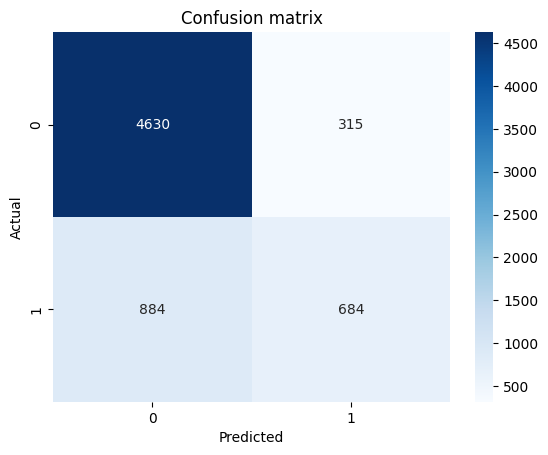

The LogReg has been successfully saved to a file: /home/roman/Desktop/ML/save_models/unbalanced/LogReg.joblib
SVC results:
Accuracy: 0.802:
Log Loss: 7.14
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      4945
           1       0.95      0.19      0.31      1568

    accuracy                           0.80      6513
   macro avg       0.87      0.59      0.60      6513
weighted avg       0.83      0.80      0.75      6513



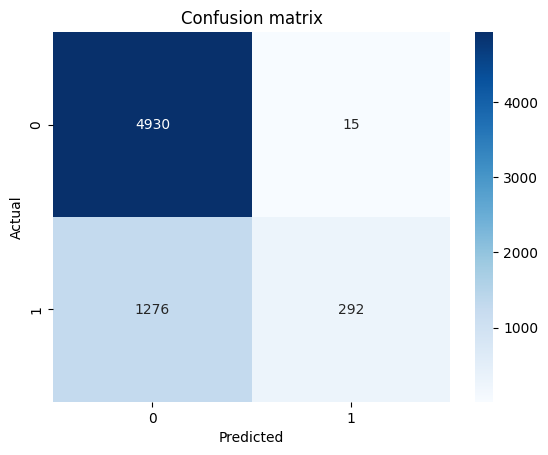

The SVC has been successfully saved to a file: /home/roman/Desktop/ML/save_models/unbalanced/SVC.joblib
KNN results:
Accuracy: 0.854:
Log Loss: 5.25
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      4945
           1       0.72      0.66      0.68      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.79      0.80      6513
weighted avg       0.85      0.85      0.85      6513



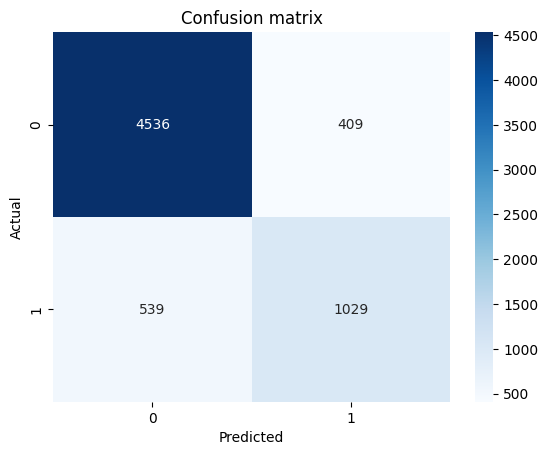

The KNN has been successfully saved to a file: /home/roman/Desktop/ML/save_models/unbalanced/KNN.joblib


In [16]:
models_fitting(models, X_train, y_train, X_test, y_test, save_models_dir_unbalanced)

DecisionTree results:
Accuracy: 0.85:
Log Loss: 5.4
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      4945
           1       0.78      0.53      0.63      1568

    accuracy                           0.85      6513
   macro avg       0.82      0.74      0.77      6513
weighted avg       0.84      0.85      0.84      6513

Feature importance:
           Feature  Importance
7     relationship    0.461862
4    education-num    0.236110
10        cap-gain    0.230847
0              age    0.034766
11        cap-loss    0.022555
12  hours-per-week    0.010984
6       occupation    0.000814
5   marital-status    0.000734
2     final_weight    0.000620
8             race    0.000375
3        education    0.000333
1        workclass    0.000000
9              sex    0.000000
13            area    0.000000


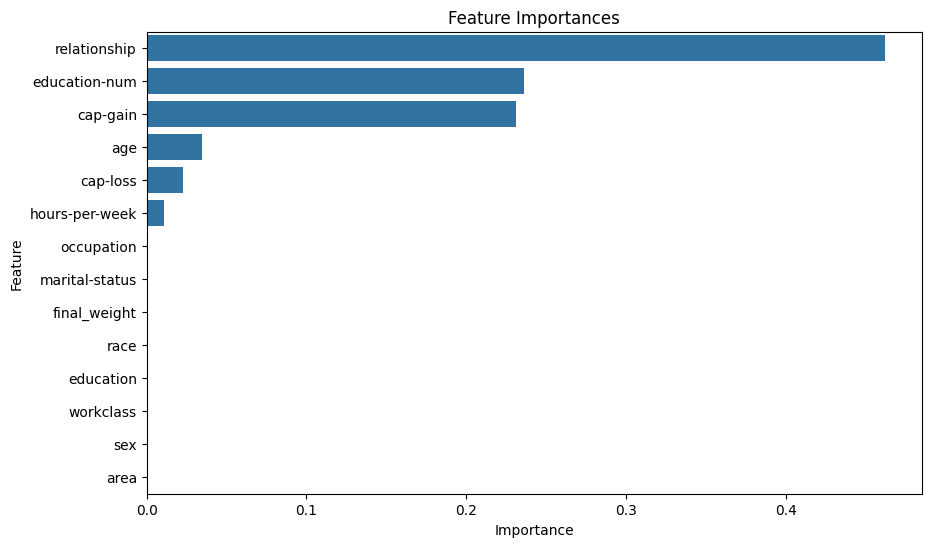

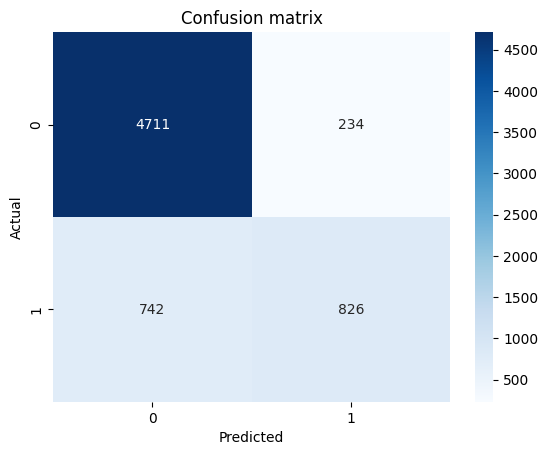

The DecisionTree has been successfully saved to a file: /home/roman/Desktop/ML/save_models/unbalanced/DecisionTree.joblib
RandomForest results:
Accuracy: 0.862:
Log Loss: 4.96
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      4945
           1       0.81      0.56      0.66      1568

    accuracy                           0.86      6513
   macro avg       0.84      0.76      0.79      6513
weighted avg       0.86      0.86      0.85      6513

Feature importance:
           Feature  Importance
10        cap-gain    0.201494
7     relationship    0.193007
4    education-num    0.148901
5   marital-status    0.127346
0              age    0.083864
12  hours-per-week    0.053842
11        cap-loss    0.053180
3        education    0.040905
6       occupation    0.034328
9              sex    0.021980
2     final_weight    0.020491
1        workclass    0.011300
13            area    0.005171
8             race  

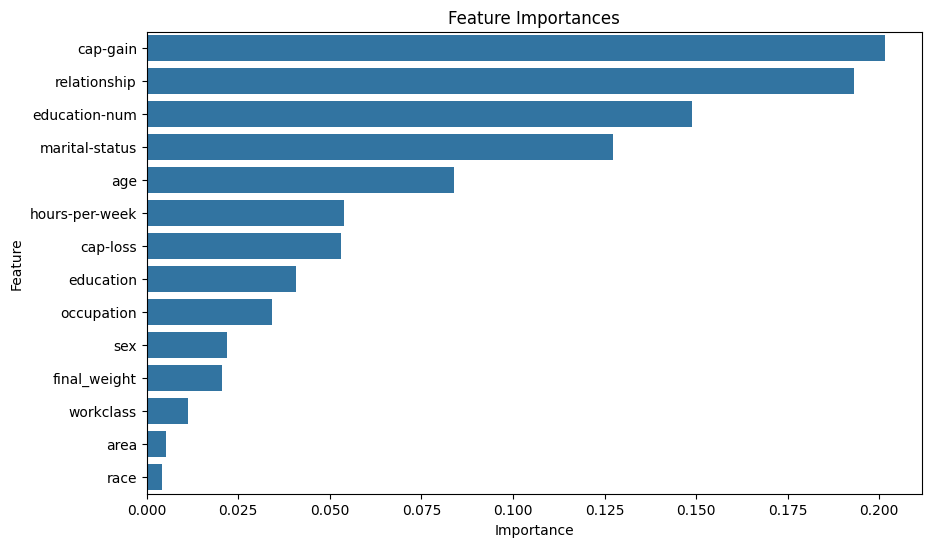

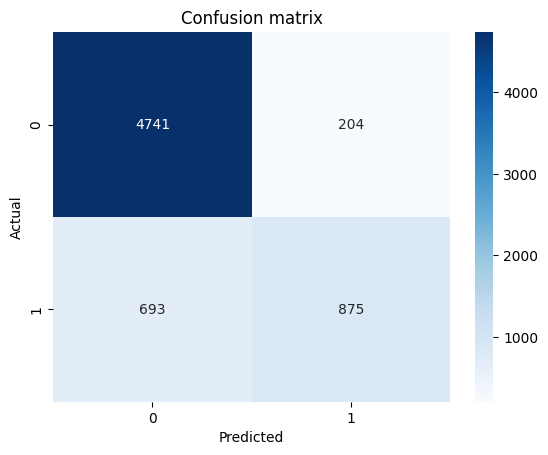

The RandomForest has been successfully saved to a file: /home/roman/Desktop/ML/save_models/unbalanced/RandomForest.joblib
Gradient_Boost results:
Accuracy: 0.872:
Log Loss: 4.62
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4945
           1       0.77      0.67      0.72      1568

    accuracy                           0.87      6513
   macro avg       0.83      0.80      0.82      6513
weighted avg       0.87      0.87      0.87      6513

Feature importance:
           Feature  Importance
7     relationship    0.269722
4    education-num    0.157965
10        cap-gain    0.155107
2     final_weight    0.108620
0              age    0.084170
12  hours-per-week    0.062624
11        cap-loss    0.050001
6       occupation    0.044008
1        workclass    0.024363
3        education    0.013042
13            area    0.010059
8             race    0.007745
5   marital-status    0.007572
9              sex

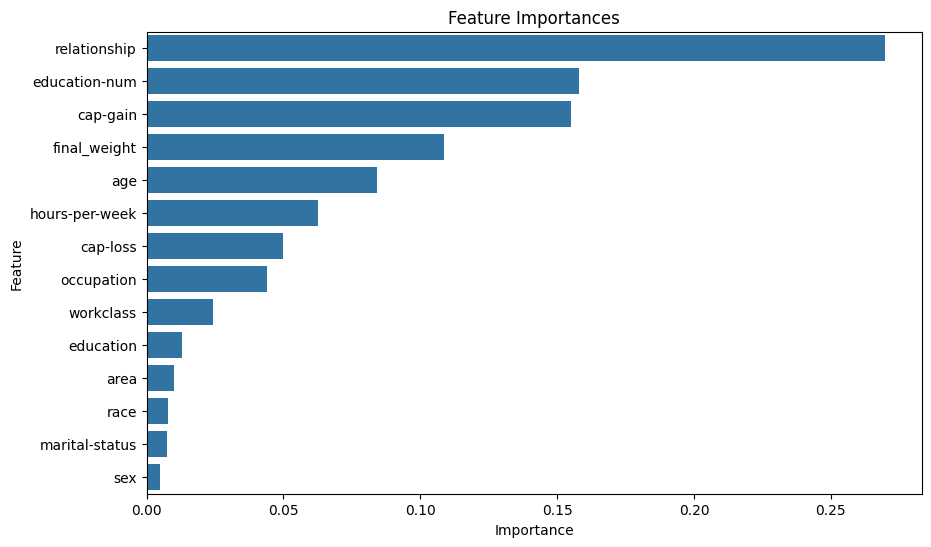

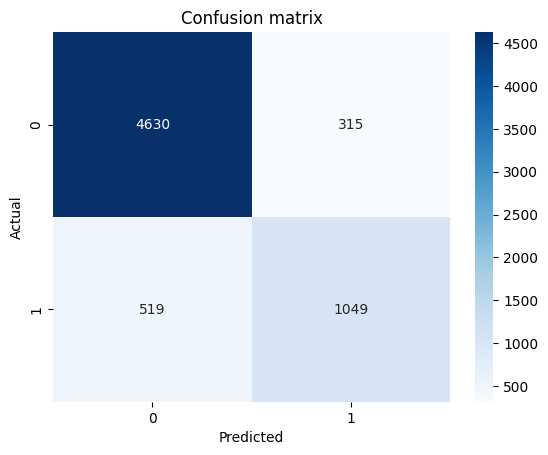

The Gradient_Boost has been successfully saved to a file: /home/roman/Desktop/ML/save_models/unbalanced/Gradient_Boost.joblib
AdaBoost results:
Accuracy: 0.859:
Log Loss: 5.1
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4945
           1       0.79      0.56      0.66      1568

    accuracy                           0.86      6513
   macro avg       0.83      0.76      0.78      6513
weighted avg       0.85      0.86      0.85      6513

Feature importance:
           Feature  Importance
4    education-num        0.16
0              age        0.14
7     relationship        0.14
5   marital-status        0.12
6       occupation        0.12
10        cap-gain        0.10
12  hours-per-week        0.10
11        cap-loss        0.06
9              sex        0.05
8             race        0.01
1        workclass        0.00
2     final_weight        0.00
3        education        0.00
13            area   

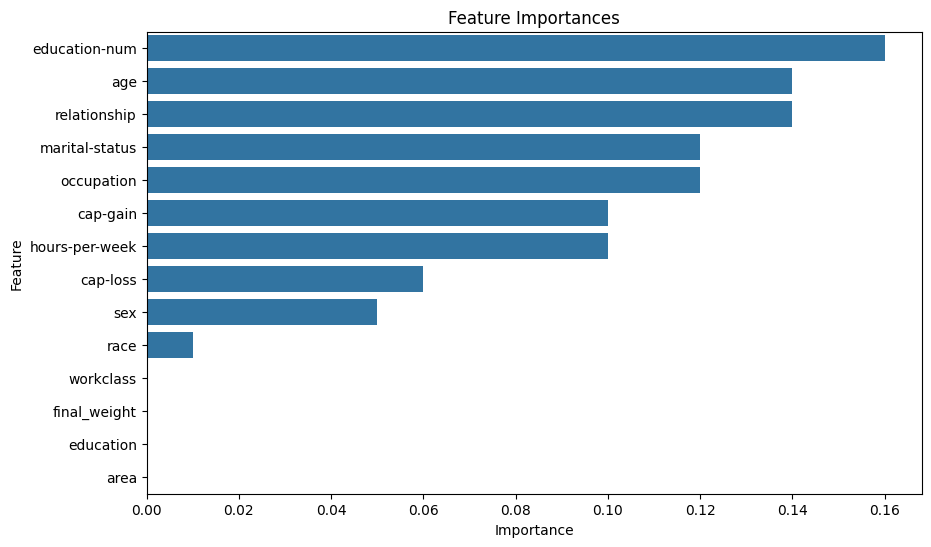

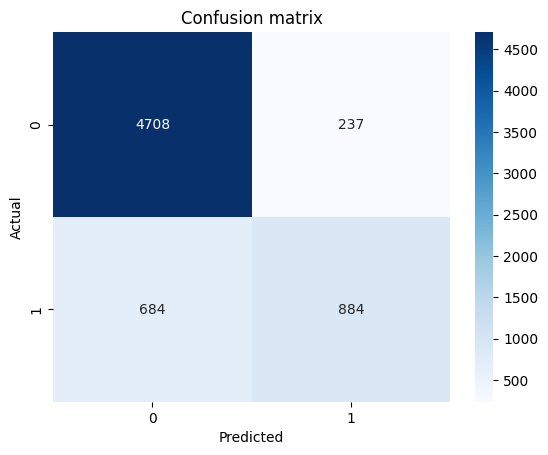

The AdaBoost has been successfully saved to a file: /home/roman/Desktop/ML/save_models/unbalanced/AdaBoost.joblib
[LightGBM] [Info] Number of positive: 6273, number of negative: 19775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240825 -> initscore=-1.148164
[LightGBM] [Info] Start training from score -1.148164
LGBM results:
Accuracy: 0.875:
Log Loss: 4.52
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4945
           1       0.78      0.66      0.72      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.82

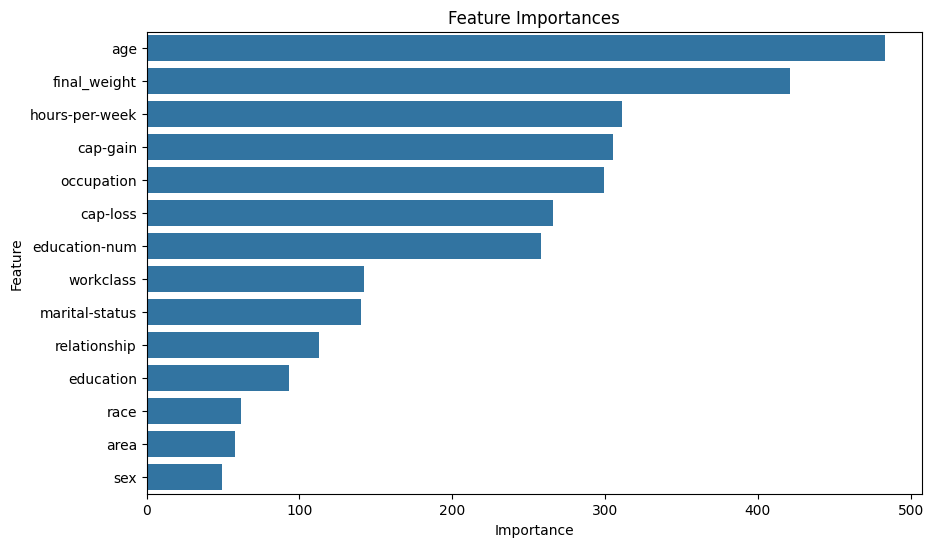

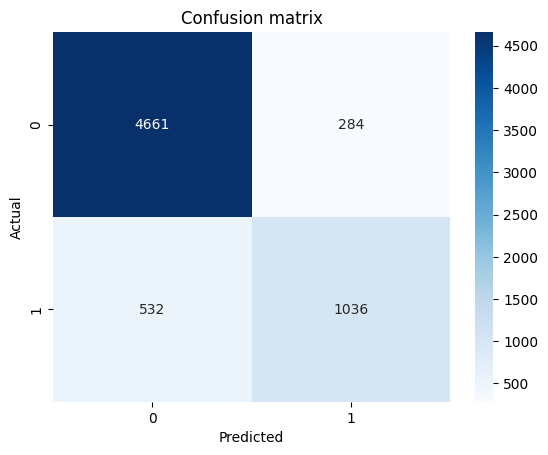

The LGBM has been successfully saved to a file: /home/roman/Desktop/ML/save_models/unbalanced/LGBM.joblib
XGBoost results:
Accuracy: 0.858:
Log Loss: 5.11
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4945
           1       0.83      0.52      0.64      1568

    accuracy                           0.86      6513
   macro avg       0.84      0.74      0.78      6513
weighted avg       0.85      0.86      0.85      6513

Feature importance:
           Feature  Importance
7     relationship    0.582010
5   marital-status    0.178009
4    education-num    0.090137
10        cap-gain    0.079091
11        cap-loss    0.024128
12  hours-per-week    0.023298
0              age    0.013090
6       occupation    0.005817
13            area    0.001857
8             race    0.001650
2     final_weight    0.000913
1        workclass    0.000000
3        education    0.000000
9              sex    0.000000


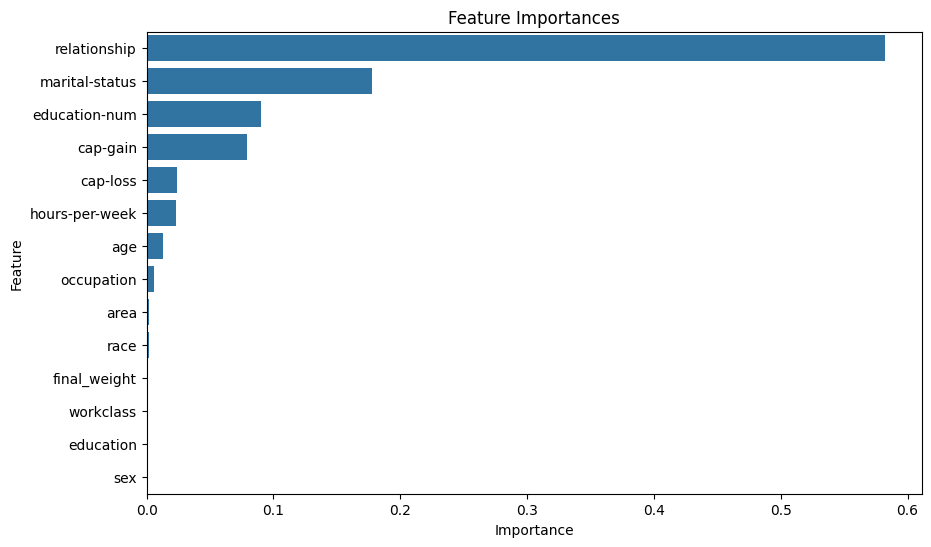

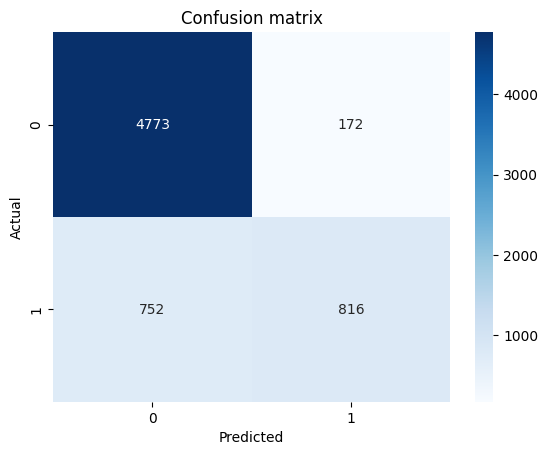

The XGBoost has been successfully saved to a file: /home/roman/Desktop/ML/save_models/unbalanced/XGBoost.joblib
CatBoost results:
Accuracy: 0.868:
Log Loss: 4.76
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4945
           1       0.79      0.62      0.69      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.78      0.80      6513
weighted avg       0.86      0.87      0.86      6513

Feature importance:
           Feature  Importance
7     relationship   23.817289
10        cap-gain   13.414489
4    education-num   11.886833
0              age   10.978685
5   marital-status   10.449106
6       occupation    9.161185
12  hours-per-week    6.565041
11        cap-loss    5.879503
9              sex    3.043198
3        education    1.833752
1        workclass    1.196147
2     final_weight    0.733818
13            area    0.581459
8             race    0.459494


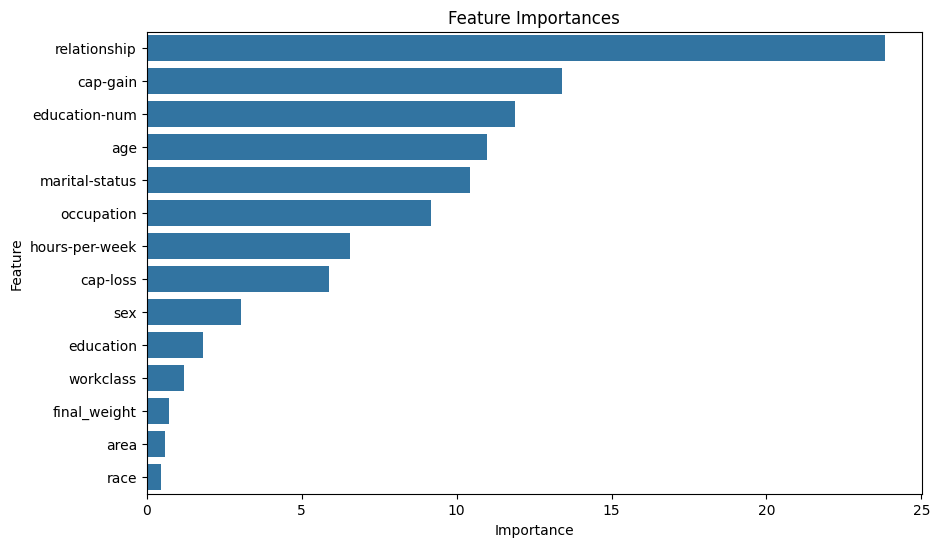

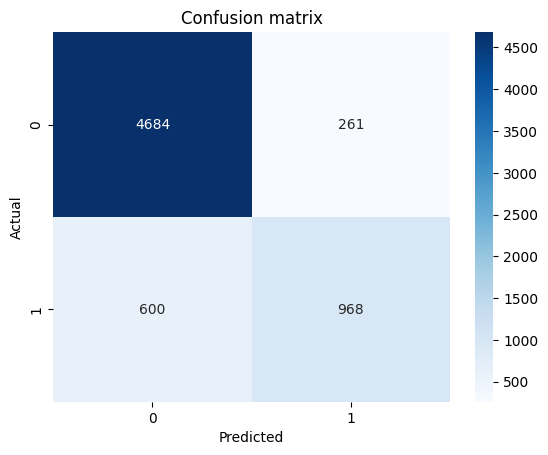

The CatBoost has been successfully saved to a file: /home/roman/Desktop/ML/save_models/unbalanced/CatBoost.joblib


In [17]:
models_fitting(models_f, X_train, y_train, X_test, y_test, save_models_dir_unbalanced, importance=True)

## Balanced data

LogReg results:
Accuracy: 0.752:
Log Loss: 8.93
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      4945
           1       0.49      0.79      0.60      1568

    accuracy                           0.75      6513
   macro avg       0.70      0.76      0.71      6513
weighted avg       0.81      0.75      0.77      6513



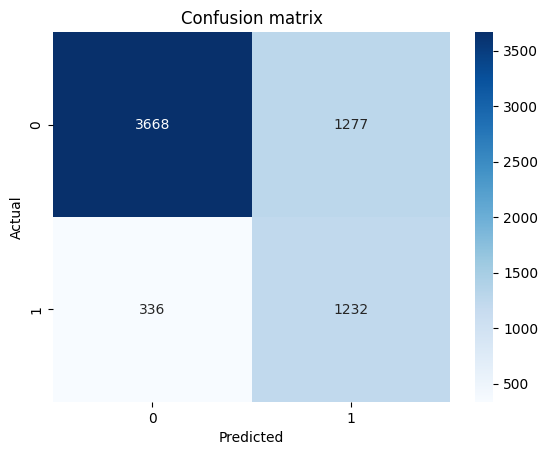

The LogReg has been successfully saved to a file: /home/roman/Desktop/ML/save_models/balanced/LogReg.joblib
SVC results:
Accuracy: 0.802:
Log Loss: 7.14
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      4945
           1       0.70      0.31      0.43      1568

    accuracy                           0.80      6513
   macro avg       0.76      0.64      0.66      6513
weighted avg       0.79      0.80      0.77      6513



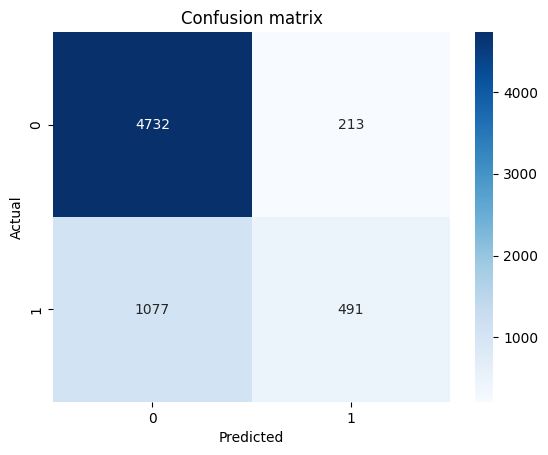

The SVC has been successfully saved to a file: /home/roman/Desktop/ML/save_models/balanced/SVC.joblib
KNN results:
Accuracy: 0.808:
Log Loss: 6.93
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      4945
           1       0.57      0.82      0.67      1568

    accuracy                           0.81      6513
   macro avg       0.75      0.81      0.77      6513
weighted avg       0.85      0.81      0.82      6513



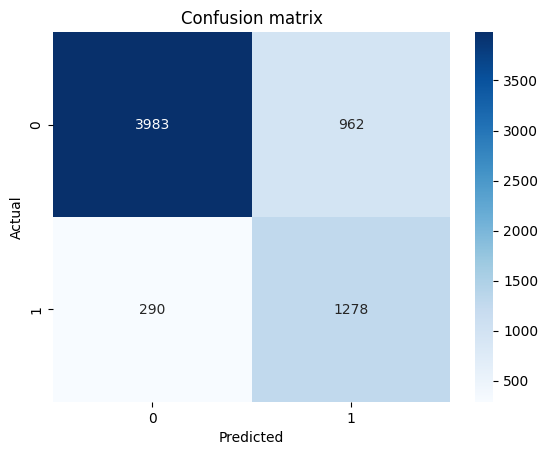

The KNN has been successfully saved to a file: /home/roman/Desktop/ML/save_models/balanced/KNN.joblib


In [18]:
models_fitting(b_models, b_X_train, b_y_train, X_test, y_test, save_models_dir_balanced)

DecisionTree results:
Accuracy: 0.771:
Log Loss: 8.26
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83      4945
           1       0.51      0.88      0.65      1568

    accuracy                           0.77      6513
   macro avg       0.73      0.81      0.74      6513
weighted avg       0.85      0.77      0.79      6513

Feature importance:
           Feature  Importance
7     relationship    0.604027
4    education-num    0.164657
10        cap-gain    0.147361
0              age    0.039531
12  hours-per-week    0.031792
11        cap-loss    0.011014
3        education    0.001520
13            area    0.000099
1        workclass    0.000000
2     final_weight    0.000000
5   marital-status    0.000000
6       occupation    0.000000
8             race    0.000000
9              sex    0.000000


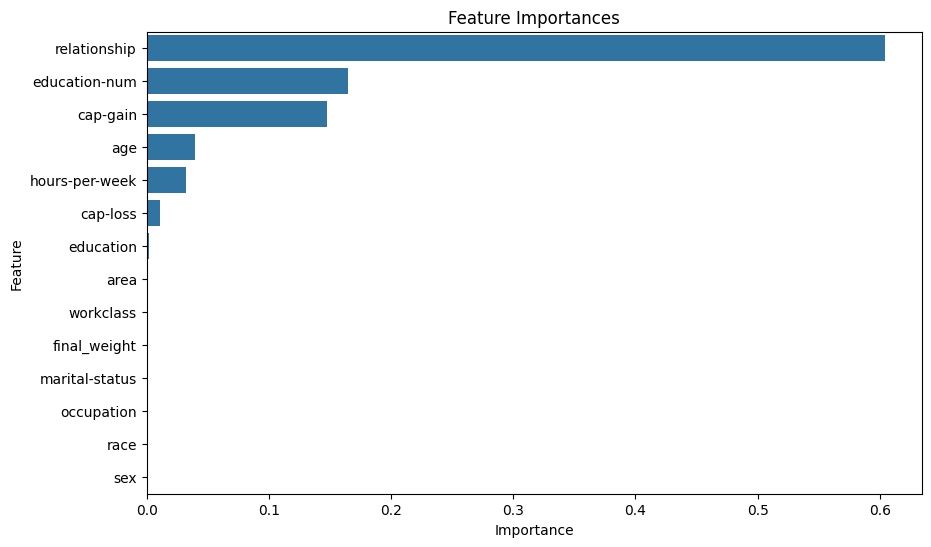

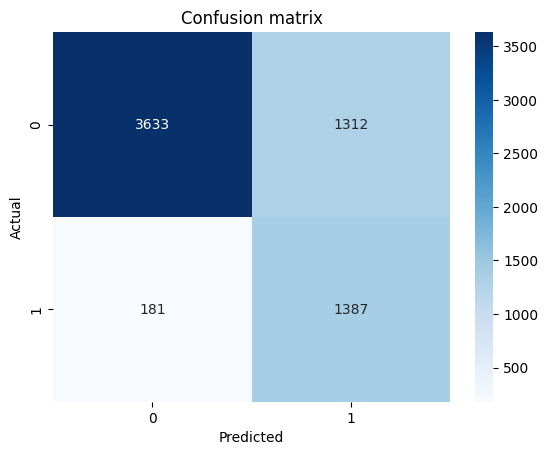

The DecisionTree has been successfully saved to a file: /home/roman/Desktop/ML/save_models/balanced/DecisionTree.joblib
RandomForest results:
Accuracy: 0.808:
Log Loss: 6.93
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      4945
           1       0.57      0.86      0.68      1568

    accuracy                           0.81      6513
   macro avg       0.76      0.83      0.77      6513
weighted avg       0.86      0.81      0.82      6513

Feature importance:
           Feature  Importance
7     relationship    0.243709
5   marital-status    0.177244
0              age    0.126646
4    education-num    0.124624
10        cap-gain    0.093615
12  hours-per-week    0.076107
9              sex    0.042514
3        education    0.036530
6       occupation    0.026774
11        cap-loss    0.017951
1        workclass    0.013535
2     final_weight    0.011147
8             race    0.005989
13            area    

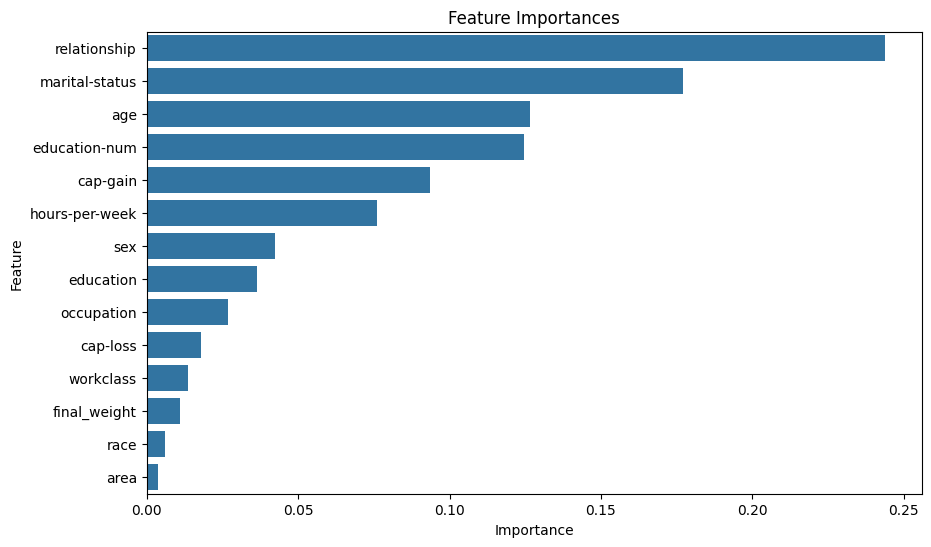

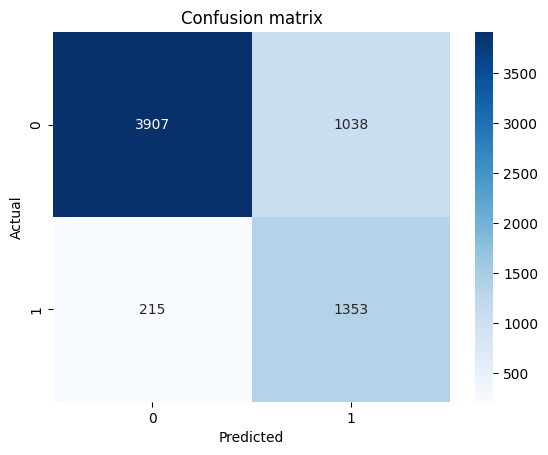

The RandomForest has been successfully saved to a file: /home/roman/Desktop/ML/save_models/balanced/RandomForest.joblib
Gradient_Boost results:
Accuracy: 0.862:
Log Loss: 4.98
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      4945
           1       0.70      0.74      0.72      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.82      0.81      6513
weighted avg       0.86      0.86      0.86      6513

Feature importance:
           Feature  Importance
7     relationship    0.373304
0              age    0.122128
4    education-num    0.120442
10        cap-gain    0.107818
12  hours-per-week    0.073365
2     final_weight    0.046786
6       occupation    0.040699
11        cap-loss    0.028726
1        workclass    0.024877
9              sex    0.020632
5   marital-status    0.013303
3        education    0.012648
8             race    0.008515
13            area  

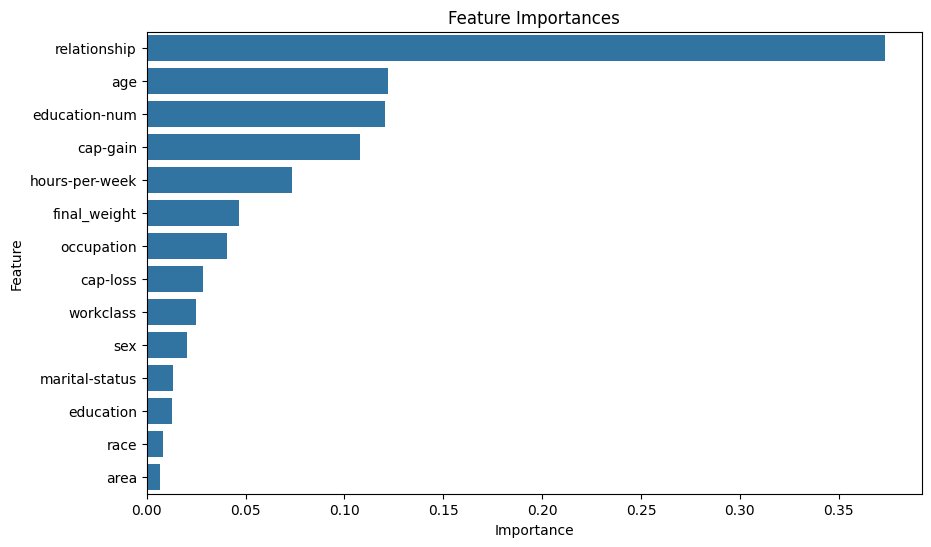

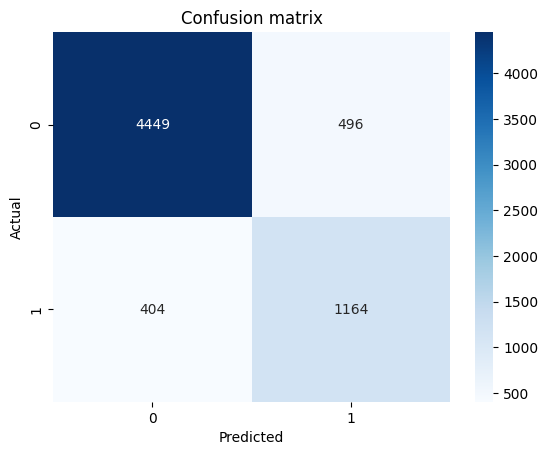

The Gradient_Boost has been successfully saved to a file: /home/roman/Desktop/ML/save_models/balanced/Gradient_Boost.joblib
AdaBoost results:
Accuracy: 0.818:
Log Loss: 6.55
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4945
           1       0.59      0.83      0.69      1568

    accuracy                           0.82      6513
   macro avg       0.76      0.82      0.78      6513
weighted avg       0.85      0.82      0.83      6513

Feature importance:
           Feature  Importance
0              age        0.16
4    education-num        0.13
7     relationship        0.13
5   marital-status        0.11
10        cap-gain        0.09
12  hours-per-week        0.09
6       occupation        0.08
9              sex        0.06
11        cap-loss        0.05
1        workclass        0.03
8             race        0.03
2     final_weight        0.02
3        education        0.02
13            area    

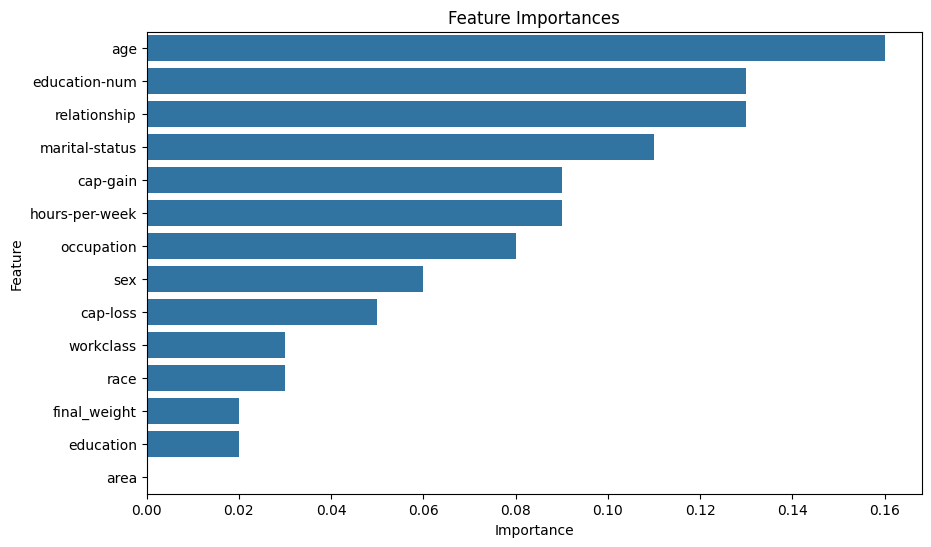

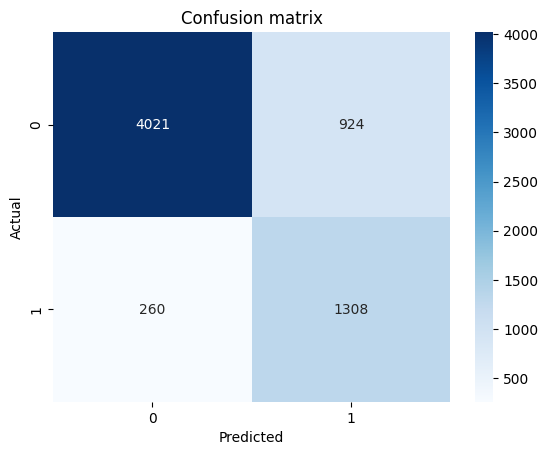

The AdaBoost has been successfully saved to a file: /home/roman/Desktop/ML/save_models/balanced/AdaBoost.joblib
[LightGBM] [Info] Number of positive: 19775, number of negative: 19775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3234
[LightGBM] [Info] Number of data points in the train set: 39550, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBM results:
Accuracy: 0.861:
Log Loss: 5.02
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      4945
           1       0.68      0.79      0.73      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.84      0.82      6513
weighted avg       0.87      0.86      0.86 

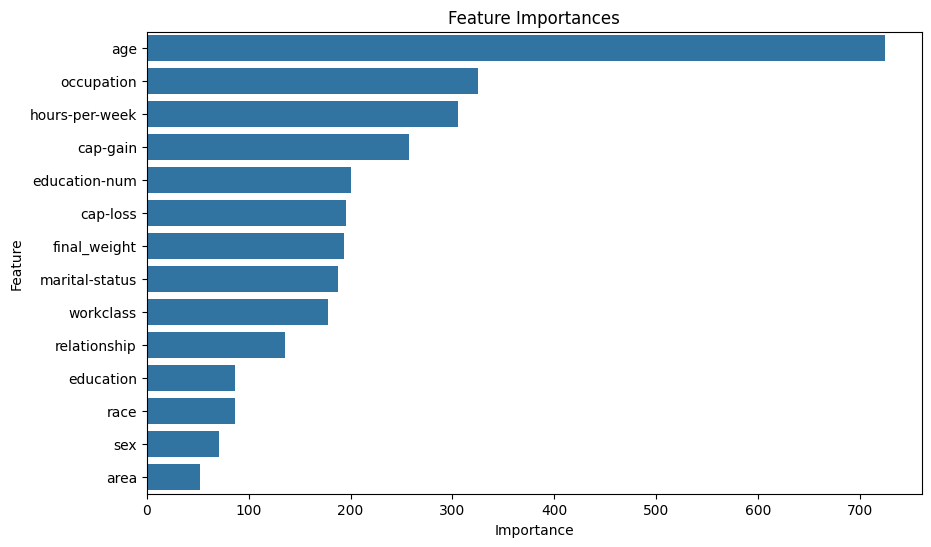

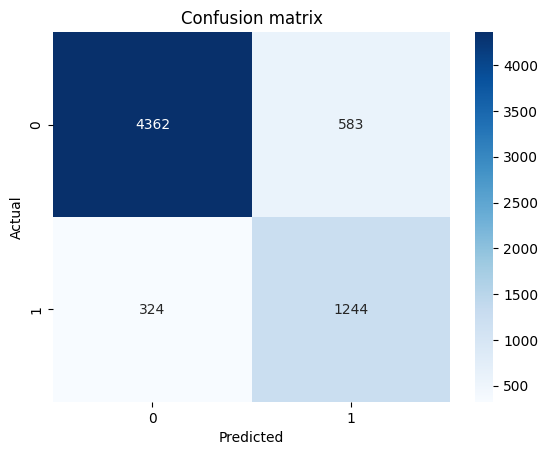

The LGBM has been successfully saved to a file: /home/roman/Desktop/ML/save_models/balanced/LGBM.joblib
XGBoost results:
Accuracy: 0.802:
Log Loss: 7.13
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      4945
           1       0.56      0.86      0.68      1568

    accuracy                           0.80      6513
   macro avg       0.75      0.82      0.77      6513
weighted avg       0.85      0.80      0.81      6513

Feature importance:
           Feature  Importance
7     relationship    0.552060
5   marital-status    0.226645
4    education-num    0.087280
10        cap-gain    0.047970
12  hours-per-week    0.024248
0              age    0.015570
11        cap-loss    0.014830
9              sex    0.012661
1        workclass    0.011253
6       occupation    0.002590
3        education    0.002098
8             race    0.001659
2     final_weight    0.001135
13            area    0.000000


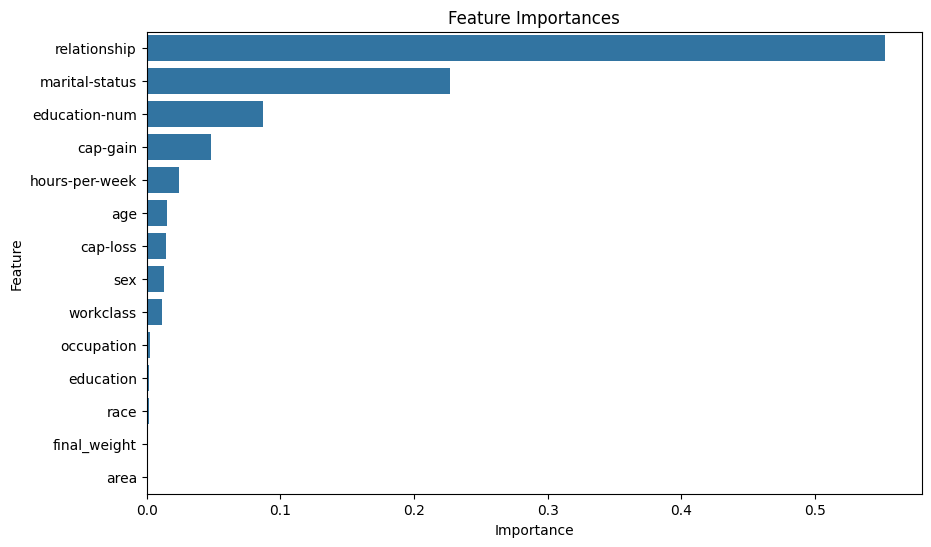

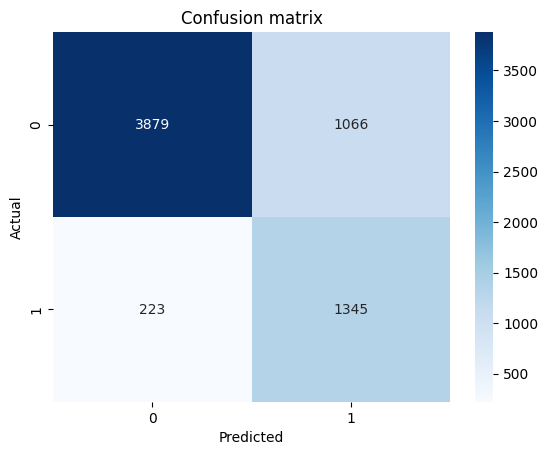

The XGBoost has been successfully saved to a file: /home/roman/Desktop/ML/save_models/balanced/XGBoost.joblib
CatBoost results:
Accuracy: 0.832:
Log Loss: 6.07
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      4945
           1       0.61      0.83      0.70      1568

    accuracy                           0.83      6513
   macro avg       0.78      0.83      0.79      6513
weighted avg       0.86      0.83      0.84      6513

Feature importance:
           Feature  Importance
7     relationship   21.358715
10        cap-gain   11.773186
0              age   11.462941
5   marital-status   10.593120
4    education-num   10.426705
6       occupation    9.010128
12  hours-per-week    7.126883
9              sex    4.970592
1        workclass    4.936637
11        cap-loss    3.223301
3        education    2.037544
8             race    1.666078
2     final_weight    0.995965
13            area    0.418206


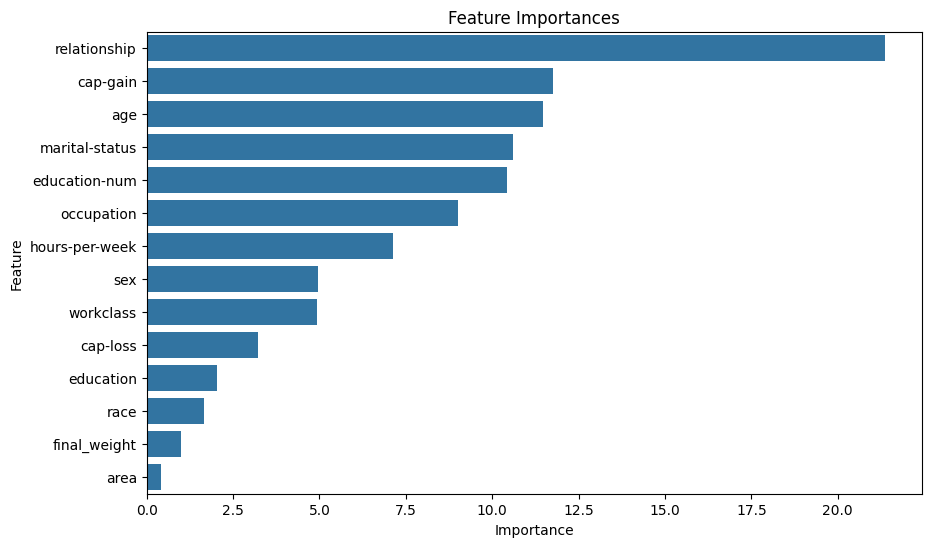

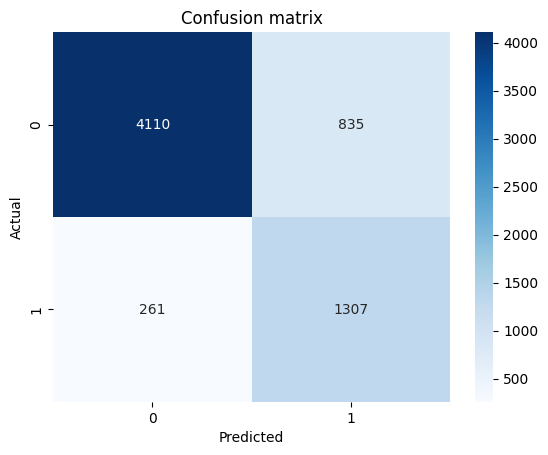

The CatBoost has been successfully saved to a file: /home/roman/Desktop/ML/save_models/balanced/CatBoost.joblib


In [19]:
models_fitting(b_models_f, b_X_train, b_y_train, X_test, y_test, save_models_dir_balanced, importance=True)

# ROC Curve

## Unbalanced data

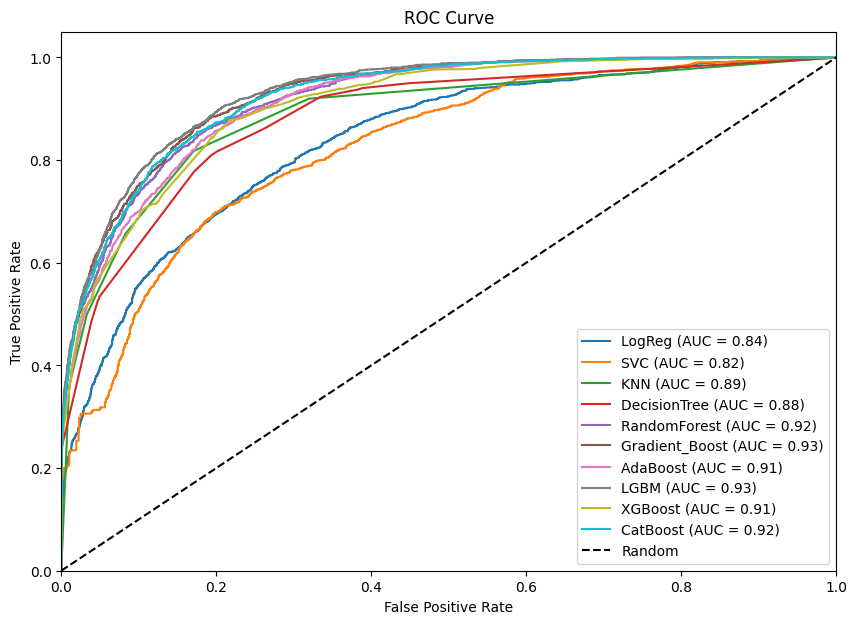

In [20]:
plot_roc_curve_and_auc({**models, **models_f}, X_test, y_test)

## Balanced data

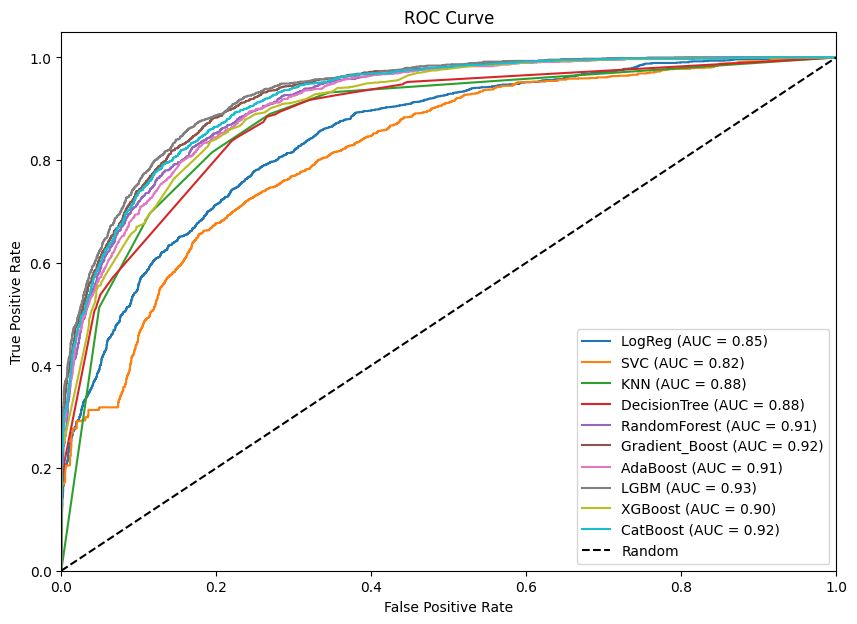

In [21]:
plot_roc_curve_and_auc({**b_models, **b_models_f}, X_test, y_test)

# Prediction test empty

In [25]:
def save_results(result, name, path):
    full_path = os.path.join(path, f"{name}.csv")
    df_results = pd.DataFrame(result)
    df_results.to_csv(full_path, index=False)
    print(f"The results from {name} has been successfully saved to a file: {full_path}")


def get_predict(model, data):
    return model.predict(data)


def models_prediction(models, data, path):
    for name, model in models.items():
        pred = get_predict(model, data)
        save_results(pred, name, path)

## Unbalanced data

In [26]:
models_prediction({**models, **models_f}, X_test_empty, os.path.join(test_empty_resuls_path, "unbalanced"))

The results from LogReg has been successfully saved to a file: /home/roman/Desktop/ML/data/results/unbalanced/LogReg.csv
The results from SVC has been successfully saved to a file: /home/roman/Desktop/ML/data/results/unbalanced/SVC.csv
The results from KNN has been successfully saved to a file: /home/roman/Desktop/ML/data/results/unbalanced/KNN.csv
The results from DecisionTree has been successfully saved to a file: /home/roman/Desktop/ML/data/results/unbalanced/DecisionTree.csv
The results from RandomForest has been successfully saved to a file: /home/roman/Desktop/ML/data/results/unbalanced/RandomForest.csv
The results from Gradient_Boost has been successfully saved to a file: /home/roman/Desktop/ML/data/results/unbalanced/Gradient_Boost.csv
The results from AdaBoost has been successfully saved to a file: /home/roman/Desktop/ML/data/results/unbalanced/AdaBoost.csv
The results from LGBM has been successfully saved to a file: /home/roman/Desktop/ML/data/results/unbalanced/LGBM.csv
The 

## Balanced data

In [27]:
models_prediction({**b_models, **b_models_f}, X_test_empty, os.path.join(test_empty_resuls_path, "balanced"))

The results from LogReg has been successfully saved to a file: /home/roman/Desktop/ML/data/results/balanced/LogReg.csv
The results from SVC has been successfully saved to a file: /home/roman/Desktop/ML/data/results/balanced/SVC.csv
The results from KNN has been successfully saved to a file: /home/roman/Desktop/ML/data/results/balanced/KNN.csv
The results from DecisionTree has been successfully saved to a file: /home/roman/Desktop/ML/data/results/balanced/DecisionTree.csv
The results from RandomForest has been successfully saved to a file: /home/roman/Desktop/ML/data/results/balanced/RandomForest.csv
The results from Gradient_Boost has been successfully saved to a file: /home/roman/Desktop/ML/data/results/balanced/Gradient_Boost.csv
The results from AdaBoost has been successfully saved to a file: /home/roman/Desktop/ML/data/results/balanced/AdaBoost.csv
The results from LGBM has been successfully saved to a file: /home/roman/Desktop/ML/data/results/balanced/LGBM.csv
The results from XGB